# Quick Start

Here you will find basic codes for processing NIRS spectra, including transforming, filtering, training/testing a machine learning model, etc. 

We will go through the regression model as shown in the paper. You can find the test dataset for classification, and it would be a good practice to modify the code for that purpose.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Try my matplotlib style that is read for publications.
# https://github.com/HighTemplar-wjiang/matplotlib-paperstyle
mpl.style.use("paper")

# You can use the ggplot style for a quick start.
# mpl.style.use("ggplot")

# Setting low dpi for fast plotting.
# Note to save a figure, please use the savefig() function for a good quality.  
plt.rcParams["figure.dpi"] = 50  

In [3]:
# Configurations.
datapath = "../data/regression/"

# Regular expression for data files.
file_pattern = "round(\d)_tube(.)_solution(?P<label>\d+?)_sample(?P<sample>\d)_.*?_(?P<scanid>.*?).csv"
reference_pattern = "round(\d)_tube(.)_solution0_sample(\d)_.*?_(.*?).csv"
re_file = re.compile(file_pattern)
re_reference = re.compile(reference_pattern)

In [4]:
# Load metadata that includes mappings from solution label to concentrations. 
df_sugar_stat = pd.read_csv(os.path.join(datapath, "_sugar_stat.csv"),skiprows=1)
dict_concentrations = df_sugar_stat.set_index("ID")["Measured Concentration (g/100 ml)"].to_dict()
print(dict_concentrations)

{0: 0.0, 1: 20.0, 2: 19.0, 3: 18.0, 4: 17.0, 5: 16.0, 6: 15.0, 7: 14.0, 8: 13.0, 9: 12.0, 10: 11.0, 11: 10.0, 12: 9.0, 13: 8.0, 14: 7.0, 15: 6.0, 16: 5.0, 17: 4.0, 18: 3.0, 19: 2.0, 20: 1.0, 21: 0.5, 22: 0.25, 23: 0.125, 24: 0.0625}


Text(0, 0.5, 'Sample Signal (unitless)')

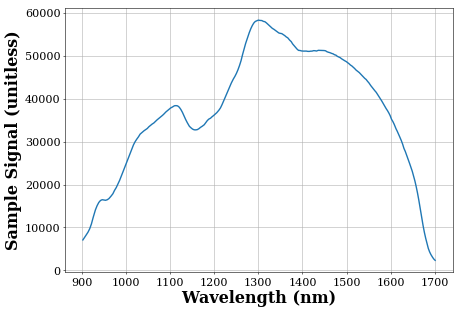

In [5]:
# Loading calibration dataset (pure water). 
# Reading csv files.
all_reference_data = []
all_files = np.array(os.listdir(datapath))
for filename in all_files:
    # Find the files that include calibration data. 
    re_result = re_reference.match(filename)
    if re_result:
        df_reference = pd.read_csv(os.path.join(datapath, filename), skiprows=21)
        all_reference_data.append(df_reference)

# Calculate the reference spectrum for calibration.
wavelength = df_reference["Wavelength (nm)"].tolist()
reference_signal = np.array([df_reference["Sample Signal (unitless)"].tolist() for df_reference in all_reference_data])
reference_signal = reference_signal.mean(axis=0)

# Visualizing the reference spectrum.
fig, ax = plt.subplots()
ax.plot(wavelength, reference_signal)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Sample Signal (unitless)")

In [6]:
# Loading all sample data.
def load_data(filepath):
    ''' Loading a single csv file that includes spectrum data.    
    '''
    df_data = pd.read_csv(filepath, skiprows=21)
    wavelength = df_data["Wavelength (nm)"]
    
    # Calibration.
    data = df_data["Sample Signal (unitless)"] / reference_signal  # Relative reflectance
    
    # Transforming to abosorbance.
    data = np.log10(1 / data)
    return wavelength, data

def load_files(datapath):
    '''Loading all files. 
    '''
    all_files = np.array(os.listdir(datapath))
    np.random.shuffle(all_files)
    
    all_data = []
    all_labels = []
    for filename in all_files:
        # Using regression expression to retrieve labels from the file names.
        re_result = re_file.match(filename)
        if re_result:
            solution_id = int(re_result["label"]) 
            label = dict_concentrations[solution_id]
            wavelength, data = load_data(os.path.join(datapath, filename))

            all_data += [np.array(data)]
            all_labels += [np.array(label)]
    return wavelength, all_data, all_labels

# Loading.
wavelength, all_data, all_labels = load_files(datapath)

# Conver to numpy
wavelength= np.array(wavelength)
all_data = np.array(all_data)
all_labels = np.array(all_labels)
all_categories = np.unique(all_labels)
label_counts = pd.value_counts(all_labels)

# Show number of spectra for each concentration (g/100ml).
print(label_counts.sort_index())
print("Number of data: " + str(len(all_data)))

0.0000     18
0.0625     18
0.1250     18
0.2500     18
0.5000     18
1.0000     18
2.0000     18
3.0000     18
4.0000     18
5.0000     18
6.0000     18
7.0000     18
8.0000     18
9.0000     18
10.0000    18
11.0000    18
12.0000    18
13.0000    18
14.0000    18
15.0000    18
16.0000    18
17.0000    18
18.0000    18
19.0000    18
20.0000    18
dtype: int64
Number of data: 450


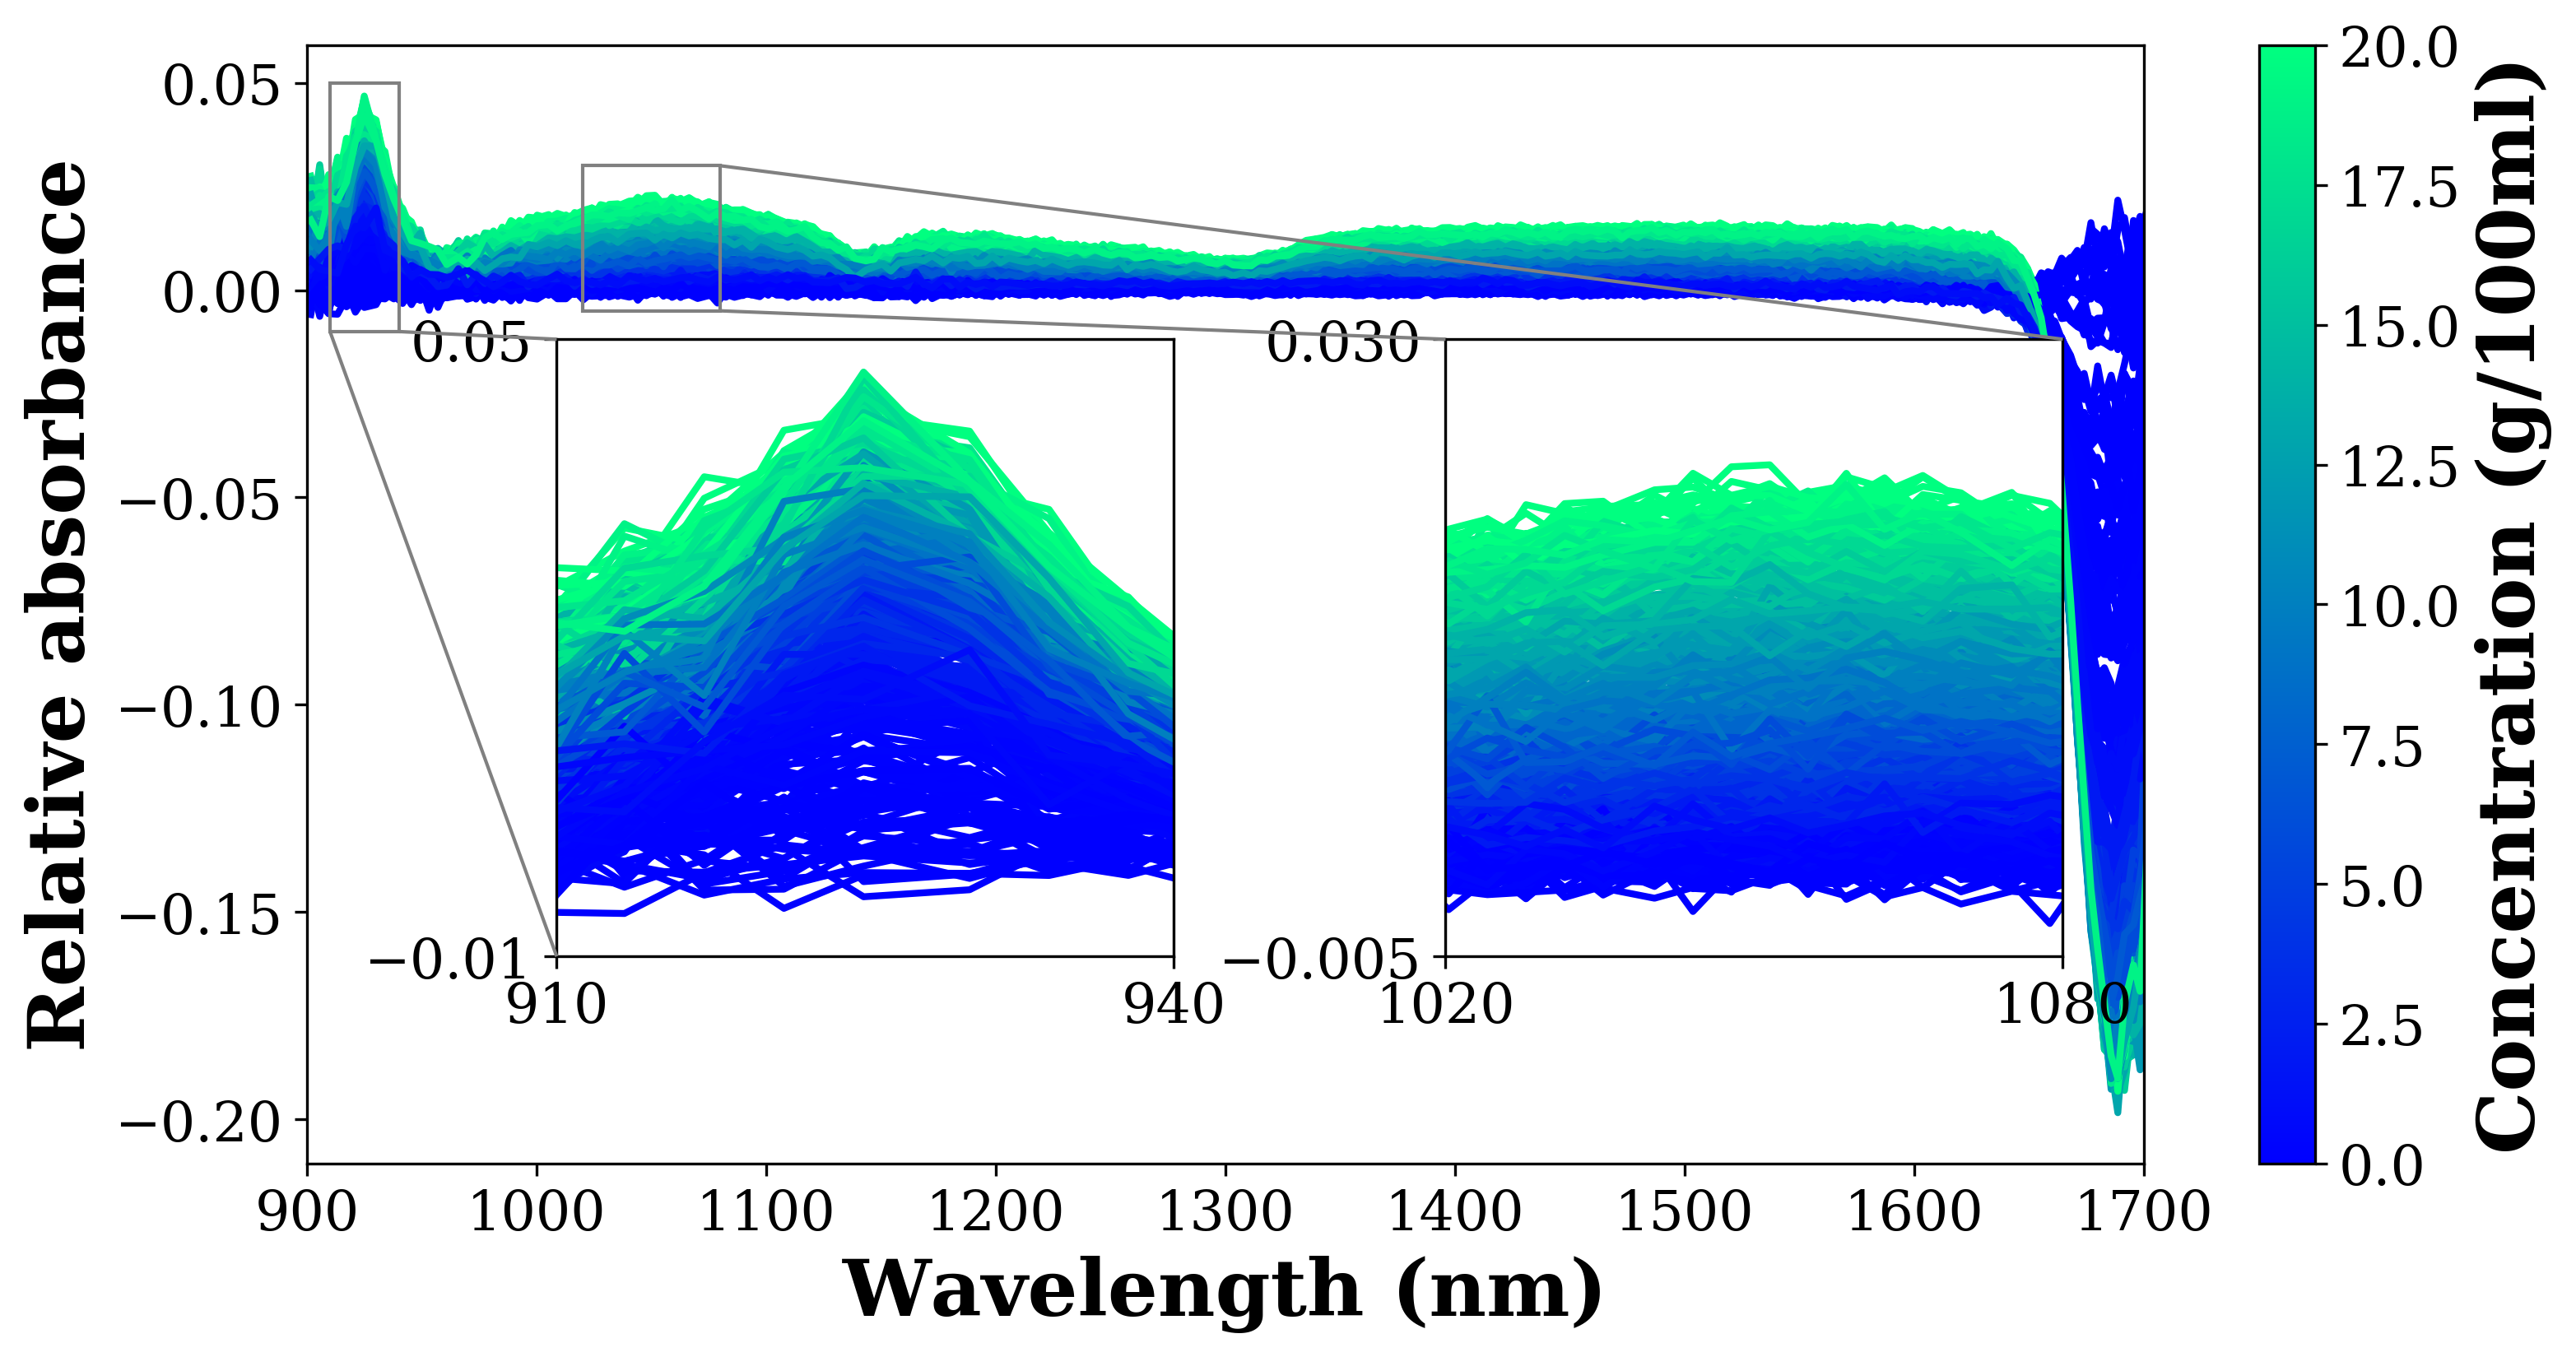

In [7]:
# Visualizing spectra. 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
# loc1, loc2 : {1, 2, 3, 4} 
def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

# Visulizing.
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes

main_fontsize=16
sub_fontsize=14

# Define mappable for colorbar creation
sm = plt.cm.ScalarMappable(cmap="winter", norm=plt.Normalize(vmin=0,vmax=20))
sm._A = [] 

# Set up the figure.
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
ax.grid(False)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Relative absorbance")
ax.set_xlim([900, 1700])

# Line specs and legends.
legend_lines = []
legend_strings = []
colors = list("bgrcm")
linetypes = ["-", "-.", "--"]
linespecs = [c+t for c in colors for t in linetypes]
cbar = fig.colorbar(sm)
cbar.set_label("Concentration (g/100ml)", rotation=90)

# Create zoomed setin figure.
# axins1 = zoomed_inset_axes(ax, 1, bbox_to_anchor=(2000, 0.2, 0.05, 0.6))  
axins1 = inset_axes(ax, 2.5, 2.5, loc=2, bbox_to_anchor=(0.2, 0.7),bbox_transform=ax.figure.transFigure) # no zoom
axins1.set_xlim(910, 940)
axins1.set_ylim(-0.01, 0.05)
axins1.set_xticks([910, 940])
axins1.set_yticks([-0.01, 0.05])

axins2 = inset_axes(ax, 2.5, 2.5, loc=2, bbox_to_anchor=(0.5, 0.7),bbox_transform=ax.figure.transFigure) # no zoom
axins2.set_xlim(1020, 1080)
axins2.set_ylim(-0.005, 0.03)
axins2.set_xticks([1020, 1080])
axins2.set_yticks([-0.005, 0.03])

# Plotting
for idx in range(all_data.shape[0]):
    rgbs = sm.to_rgba(all_labels[idx])
    line, = ax.plot(wavelength, all_data[idx, :], color=rgbs)
    
    # Zoom-in area.
    axins1.plot(wavelength, all_data[idx, :], color=rgbs)
    axins2.plot(wavelength, all_data[idx, :], color=rgbs)
    
    # Legend.
    label = str(all_labels[idx]) + "g/100ml"
    if label not in legend_strings:
        legend_lines += [line]
        legend_strings += [label]

# Mark the zoom-in area.
mark_inset(ax, axins1, loc1a=2, loc1b=4, loc2a=3, loc2b=3, fc="none", ec="0.5", zorder=20)
mark_inset(ax, axins2, loc1a=1, loc1b=1, loc2a=2, loc2b=4, fc="none", ec="0.5", zorder=20)

plt.show()

In [8]:
# Filtering.
# You can play with different filtering methods by commenting out some lines. 

import scipy.signal
from sklearn.preprocessing import scale

def slice_spectrum(wavelength, spectrum, start, end):
    '''Slicing the spectrum by giving start and end wavelengths.'''
    idx_start = np.argmin(abs(np.array(wavelength) - start))
    idx_end = np.argmin(abs(np.array(wavelength) - end)) + 1
    return wavelength[idx_start:idx_end], spectrum[idx_start:idx_end]

def preprocess(wavelength, datasets, labels, start_wavelength=900, end_wavelength=1700):
    '''Preprocessing spectrum.'''  
    # Processing.
    data_processed = []
    min_num = 1.
    max_num = 0.
    for idx in range(datasets.shape[0]):
        # Filtering.
        filtered = datasets[(idx), :]
#         filtered = scipy.signal.savgol_filter(filtered, window_length=11, polyorder=3)
#         filtered = np.log(1/filtered) / 10
#         filtered = np.gradient(filtered) # First-order gradient
#         filtered = np.gradient(filtered) # Second-order gradient
        filtered = scipy.signal.savgol_filter(filtered, window_length=21, polyorder=3)
#         filtered = np.gradient(filtered) # Third-order gradient
#         filtered = filtered / np.sum(filtered)
#         filtered = scale(np.transpose(filtered), with_mean=True, with_std=False)
        wavelength_sub, filtered = slice_spectrum(wavelength, filtered, start_wavelength, end_wavelength)
        data_processed.append(filtered)
    
    return data_processed

# Processing.
all_data_processed = preprocess(wavelength, all_data, all_labels)

# Converting to numpy array.
all_data_processed = np.array(all_data_processed)
print(all_data_processed.shape)

/anaconda3/envs/data/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(450, 228)


In [9]:
# Training regression models.
import time
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

# Creating models.
svr_model = SVR(C=100., gamma=0.5, kernel=u'rbf', tol=0.1, epsilon=.01)
rfr_model = RandomForestRegressor(n_estimators=10)
slr_model = LinearRegression() # Selected linear regression
lr_model = LinearRegression()
mlp_model = MLPRegressor(hidden_layer_sizes=(228,), activation="identity", solver="lbfgs")

all_models = [slr_model, lr_model, svr_model, rfr_model, mlp_model]
all_model_names = ["SSLR", "MLR", "SVR", "RFR", "MLP"]
model_dict = dict((all_model_names[idx], all_models[idx]) for idx in range(len(all_models)))

In [10]:
# Spliting train / test data.
from copy import deepcopy

train_data = []
train_labels = []
test_data = []
test_labels = []

# Define test categories
train_points = [0, 0.125, 0.5] + list(range(2, 21 ,2))
train_categories = []
for train_category in train_points:
    train_categories.append(all_categories[np.argmin(abs(all_categories - train_category))])

# Splitting.
total_number = np.min(label_counts)
train_number = int(total_number * 0.5)
test_number = total_number - train_number
for category in all_categories:
    indexes = np.where(all_labels == category)[0]
    
    if category in train_categories:
        train_indexes= indexes
        test_indexes = []
    else:
        train_indexes = []
        test_indexes = indexes

    # For splitting-and-test
#     train_indexes = indexes[:train_number]
#     test_indexes = indexes[train_number:train_number+test_number]

    print(category)
    print("Train: {} \n Test: {}".format(str(train_indexes), str(test_indexes)))
    # Split data.
    train_data += [all_data_processed[int(idx), :] for idx in train_indexes]
    train_labels += [all_labels[int(idx)] for idx in train_indexes]
    test_data += [all_data_processed[int(idx), :] for idx in test_indexes]
    test_labels += [all_labels[int(idx)] for idx in test_indexes]

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

0.0
Train: [ 27  52  57  65  94 116 120 157 171 181 219 247 249 329 352 362 376 423] 
 Test: []
0.0625
Train: [] 
 Test: [ 16  33 114 122 131 143 144 162 284 314 319 332 351 359 414 432 440 442]
0.125
Train: [ 23  75 102 113 185 205 233 253 256 272 326 327 341 369 390 394 409 410] 
 Test: []
0.25
Train: [] 
 Test: [ 63  82 104 126 133 164 168 183 186 266 300 306 321 325 349 360 388 424]
0.5
Train: [ 28  46  53  72  93 149 199 200 232 262 271 279 303 331 355 391 438 441] 
 Test: []
1.0
Train: [] 
 Test: [  7  62  92 115 135 140 141 150 154 180 184 210 263 346 400 402 405 448]
2.0
Train: [ 13  36  49  70 152 204 228 236 259 268 278 297 298 304 305 337 382 447] 
 Test: []
3.0
Train: [] 
 Test: [  6  21  80 108 123 163 167 175 176 179 193 208 275 285 301 324 343 386]
4.0
Train: [ 22  48  50  86  88 119 139 151 218 220 244 251 260 277 280 378 383 408] 
 Test: []
5.0
Train: [] 
 Test: [  4  26  61 100 112 129 161 169 196 202 216 250 282 283 286 372 393 397]
6.0
Train: [ 12  40  54  56  59  6

In [11]:
# Training.
# Run multiple times for testing.
import pickle
from sklearn.metrics import r2_score, mean_squared_error

start_idx, end_idx = 0, -1
feature_indexes = list(range(len(wavelength)))

train_rmse_iter = []
train_r2_iter = []
test_rmse_iter = []
test_r2_iter = []
for model_name, model in zip(all_model_names, all_models):
    print("\n" + model_name, end=":")
    train_rmse = []
    train_r2 = []
    test_rmse = []
    test_r2 = []
    for idx_train in range(1):
        print(idx_train, end=" ")
        
        # Training.
        model.fit(train_data[:, feature_indexes], train_labels)
        predictions = model.predict(train_data[:, feature_indexes])
        
        # Train acc.
        predictions[predictions<0] = 0
        r2 = r2_score(train_labels, predictions)
        rmse = np.sqrt(mean_squared_error(train_labels, predictions))
        train_rmse.append(rmse)
        train_r2.append(r2)

        # Test acc.
        predictions = model.predict(test_data[:, feature_indexes])
        predictions[predictions<0] = 0
        r2 = r2_score(test_labels, predictions)
        rmse = np.sqrt(mean_squared_error(test_labels, predictions))
        test_rmse.append(rmse)
        test_r2.append(r2)
        
        # Export models.
#         model_path = "./models/{}_regression".format(model_name)
#         print(model_path)
#         with open(model_path, "wb") as f:
#             pickle.dump(model, f)

    print("\nTrain: RMSE={:.4f}, R2={:.4f} ; Var={:e}".format(np.mean(train_rmse), np.mean(train_r2), np.var(train_rmse)))
    print("Test:  RMSE={:.4f}, R2={:.4f} ; Var={:e}".format(np.mean(test_rmse), np.mean(test_r2), np.var(test_rmse)))
    
    train_rmse_iter.append(train_rmse)
    train_r2_iter.append(train_r2)
    test_rmse_iter.append(test_rmse)
    test_r2_iter.append(test_r2)


SSLR:0 
Train: RMSE=0.0491, R2=0.9999 ; Var=0.000000e+00
Test:  RMSE=1.0702, R2=0.9720 ; Var=0.000000e+00

MLR:0 
Train: RMSE=0.0491, R2=0.9999 ; Var=0.000000e+00
Test:  RMSE=1.0702, R2=0.9720 ; Var=0.000000e+00

SVR:0 
Train: RMSE=0.5244, R2=0.9940 ; Var=0.000000e+00
Test:  RMSE=0.5681, R2=0.9921 ; Var=0.000000e+00

RFR:0 
Train: RMSE=0.1270, R2=0.9997 ; Var=0.000000e+00
Test:  RMSE=0.6518, R2=0.9896 ; Var=0.000000e+00

MLP:0 
Train: RMSE=0.2675, R2=0.9984 ; Var=0.000000e+00
Test:  RMSE=0.3006, R2=0.9978 ; Var=0.000000e+00


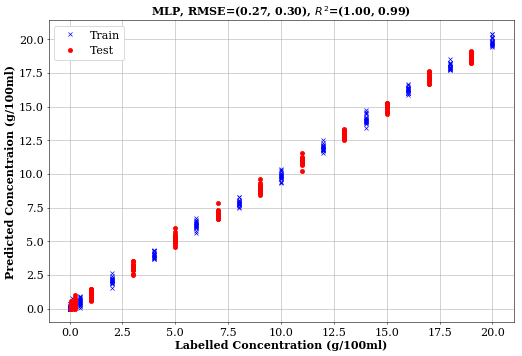

In [12]:
# Visualizing results.
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("Labelled Concentration (g/100ml)", fontsize=main_fontsize, fontweight="bold")
ax.set_ylabel("Predicted Concentraion (g/100ml)", fontsize=main_fontsize, fontweight="bold")

# Choose the model to visualize. 
model_name = "MLP"
model_v = model_dict[model_name]

# Plot.
predictions_train = model_v.predict(train_data)
predictions_train[predictions_train<0] = 0
predictions_test = model_v.predict(test_data)
predictions_test[predictions_test<0] = 0
rmse_train = np.sqrt(mean_squared_error(train_labels, predictions_train))
rmse_test = np.sqrt(mean_squared_error(test_labels, predictions_test))
r2_train = rfr_model.score(train_data, train_labels)
r2_test = rfr_model.score(test_data, test_labels)
# print("RMSE: " + str(rmse_train))
ax.plot(train_labels, predictions_train, "xb", label = "Train")
ax.plot(test_labels, predictions_test, "or", label="Test")
ax.set_title("{}, RMSE=({:.2f}, {:.2f}), $R^2$=({:.2f}, {:.2f})".format(model_name, rmse_train, rmse_test, r2_train, r2_test), 
             fontsize=main_fontsize, fontweight="bold")
ax.legend()

# Save figure.
# fig.savefig("./figures/rf_regression.pdf")